# Salary Prediction Project - Solution/Model

The scripts in this notebook are used to build the predictive models.


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


## Scripts for Preparing the Data for Training

In [3]:
#Functions
def load_file(file):
    '''load csv file to pd dataframe'''
    return pd.read_csv(file)

def consolidate_data(df1, df2, key=None, left_index=False, right_index=False):
    '''perform an inner join to return only records that are present in both dataframes'''
    return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)

def clean_data(raw_df):
    '''remove rows that contain salary <= 0 or duplicate job IDs'''
    clean_df = raw_df.drop_duplicates(subset='jobId')
    clean_df = clean_df[clean_df.salary>0]
    return clean_df
# In the Discover step, the outliers are identified and removed based on a criteria.

def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)#,ignore_index=False)

def get_target_df(df, target):
    '''returns target dataframe'''
    return df[target]

def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')

## Data Preparation Steps

In [4]:
#define inputs
train_feature_file = 'data/train_features.csv'
train_target_file = 'data/train_salaries.csv'
test_feature_file = 'data/test_features.csv'

#define variables
categorical_vars = ['jobType', 'degree', 'major', 'industry'] #CompanyId doesn't seem to have any effect on salary, so it's removed
numeric_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'

#load data
print("Loading data")
feature_df = load_file(train_feature_file)
target_df = load_file(train_target_file)
test_df = load_file(test_feature_file)

#consolidate training data
raw_train_df = consolidate_data(feature_df, target_df, key='jobId')

#clean, shuffle, and reindex training data -- shuffling improves cross-validation accuracy
clean_train_df = shuffle(clean_data(raw_train_df)).reset_index()

#encode categorical data and get final feature dfs
print("Encoding data")
feature_df = one_hot_encode_feature_df(clean_train_df, cat_vars=categorical_vars, num_vars=numeric_vars)
test_df = one_hot_encode_feature_df(test_df, cat_vars=categorical_vars, num_vars=numeric_vars)

#get target df
target_df = get_target_df(clean_train_df, target_var)

Loading data
Encoding data


In [5]:
feature_df.describe()

,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_BACHELORS,degree_DOCTORAL,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
count,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,...,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000,999995.000000
mean,0.124779,0.124370,0.125046,0.124972,0.124593,0.125121,0.125887,0.125235,0.175496,0.175363,...,0.058410,0.142942,0.142820,0.142867,0.142756,0.142771,0.142640,0.143206,11.992407,49.529381
std,0.330468,0.330003,0.330771,0.330687,0.330257,0.330856,0.331722,0.330985,0.380391,0.380277,...,0.234518,0.350014,0.349889,0.349937,0.349824,0.349839,0.349705,0.350283,7.212390,28.877721
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,25.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,50.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,75.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,24.000000,99.000000


In [6]:
#initialize model list and dictionaries
models = []
mean_mse = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = 2

#shared model paramaters
verbose_lvl = 0

## Training Models without hyperparameter tuning

In [7]:
#Training Default Models
lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
rf = RandomForestRegressor(random_state=3)
gbm = GradientBoostingRegressor()
models.extend([lr, lr_std_pca, rf, gbm])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.4347076792676
Standard deviation during CV:
 0.7762983006231537

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 384.4389794016031
Standard deviation during CV:
 0.7765280635963165

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_d

/home/mahdiazhari/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Model:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Average MSE:
 375.80010509827554
Standard deviation during CV:
 0.6926225003225


Without tuning of hyperparameters for Random Forest and Gradient Boosting Regressor, we obtained an average MSE of 464.23 and 375.82 respectively. 

## Training Models with Hyperparameter Tuning

### Random Forest Regressor

#### Grid Search Parameter Tuning
I will be using Grid Search to Tune the Random Forest Regressor

In [9]:
#Utilize grid search to select the best parameters
grid_search_params ={
    'max_depth': [None,1,25,30],
    'n_estimators':[100,200, 500],
    'max_features': ['auto', 10,20],
    'random_state':[3]
}

rf_grid_search = GridSearchCV(RandomForestRegressor(), grid_search_params, n_jobs = -1, verbose = 1, cv = 3, scoring= 'neg_mean_squared_error')


After a long process, I obtained the following optimal hyperparameters.

In [11]:
n_estimators=150 
max_depth=25 
min_samples_split=60 
max_features=30

In [12]:
rf_best_params = RandomForestRegressor(n_estimators=150, max_depth=25 , min_samples_split=60, max_features=30, random_state=3)

### Gradient Boosting Regressor

#### Best Params

In [13]:
n_estimators=150
max_depth=5
loss='ls'

In [14]:
gbm_best_params = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls')

## Comparison of All Models

In [17]:
models.extend([rf_best_params, gbm_best_params])

In [18]:
#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.4347076792676
Standard deviation during CV:
 0.7762983006231537

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 384.4389794016031
Standard deviation during CV:
 0.7765280635963165

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_d

The Best performing model is the Hyperparameter tuned Gradient Boosting Regressor with an average MSE of 357.

In [19]:
#choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)

#train model on entire dataset
model.fit(feature_df, target_df)

#create predictions based on test data
predictions = model.predict(test_df)


Predictions calculated using model with lowest MSE:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


#### Feature Importances

In [20]:
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature_importances_
    importances = [0]*len(feature_df.columns)
    
feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

#save results
save_results(model, mean_mse[model], predictions, feature_importances)

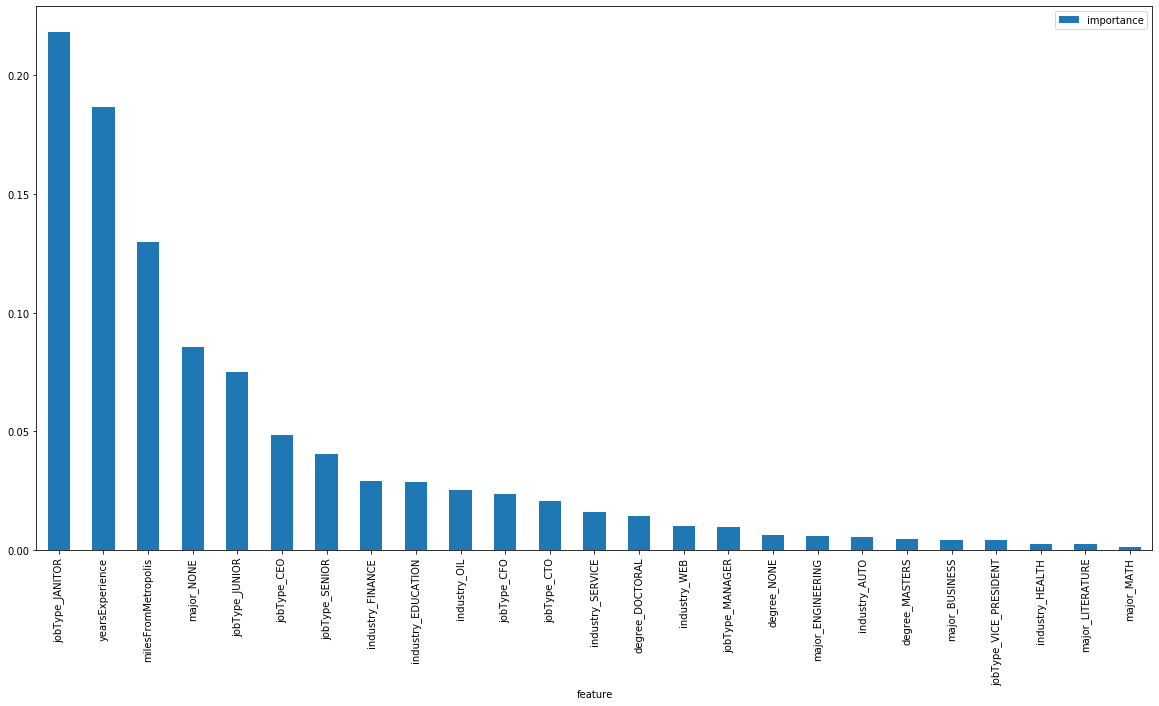

In [21]:
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

In [22]:
!cat model.txt

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
!head feature_importances.csv

feature,importance
jobType_JANITOR,0.21821626611046907
yearsExperience,0.18674393884615448
milesFromMetropolis,0.12982581082340036
major_NONE,0.08568446332745443
jobType_JUNIOR,0.07474639549685048
jobType_CEO,0.04855808603120556
jobType_SENIOR,0.04018338525260553
industry_FINANCE,0.028895711736241815
industry_EDUCATION,0.02874189275357712


We can see that for predicting salaries:
- Whether someone is a Janitor ranks as the most important feature
- Years of experience and Miles from the Metropolis comes in next
- Having a Major is ranked fourth